In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# PIPELINES FOR DEPLOYMENT

### Final Score Calculation

The **Final Score** is calculated as:

$$
\text{Final Score} = \text{Cosine Similarity Matrix} \times \text{Sentiment Score} \times \text{Cluster Boost}
$$

where:

- **Sentiment Score** is defined as:
  $$
  \text{Sentiment Score} = 1 + \text{Weighted Sentiment}
  $$
- **Cluster Boost** is a constant:
  $$
  \text{Cluster Boost} = 1.2
  $$

# 1. TF-IDF Matrix

## 1.1 Cosine Similatiry Matrix from transcripts

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Create tfidf matrix: create vectors from video_transcripts
def create_tfidf_matrix(df):
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
    
    return tfidf_vectorizer, tfidf_matrix

# Create cosine_sim_matrix: matrix based on similarity of tfidf vectors
def calculate_cosine_similarity(tfidf_matrix, video_ids):
    cosine_sim_matrix = cosine_similarity(tfidf_matrix)
    cosine_sim_triangular = np.triu(cosine_sim_matrix, k=0)
    cosine_sim_df = pd.DataFrame(cosine_sim_triangular, index=video_ids, columns=video_ids)
    return cosine_sim_df

In [3]:
# Load dataframe
df_content = pd.read_csv('../data/clean_data/df_content.csv')
df = df_content.copy()

# Create tfidf model
tfidf_vectorizer, tfidf_matrix = create_tfidf_matrix(df)

# Create cosine_sim matrix from video_transcripts
cosine_sim_matrix = calculate_cosine_similarity(tfidf_matrix, df['video_id'])

cosine_sim_matrix.iloc[:5, :5]

video_id,qtlUwwtvuEg,QaoDXYYtgK0,PqDwddEHswU,B-Y7rnOa43w,vyit-1zKsZ4
video_id,,,,,
qtlUwwtvuEg,1.0,0.065733,0.061912,0.151126,0.095740
QaoDXYYtgK0,0.0,1.000000,0.065913,0.060257,0.197272
PqDwddEHswU,0.0,0.000000,1.000000,0.045326,0.143175
B-Y7rnOa43w,0.0,0.000000,0.000000,1.000000,0.050299
vyit-1zKsZ4,0.0,0.000000,0.000000,0.000000,1.000000


# 2. Sentiment Score from comments

In [4]:
# Load the data output from the Emotion Analysis Score
df_emotion_score = pd.read_csv("../data/clean/df_videoid_emotionscore.csv/part-00000-1f04c136-e788-4899-92fa-efb423e4fcd4-c000.csv", header=None)

# Rename columns
df_emotion_score.rename(columns={0: 'video_id', 1: 'weighted_sentiment'}, inplace=True)

In [5]:
# Merge the transcript and emotion_score dataframes
df_merged = df_content.merge(df_emotion_score, on='video_id', how='left')

# Set weighted_sentiment as '0' for videos without comments
df_merged['weighted_sentiment'] = df_merged['weighted_sentiment'].fillna(float(0))

In [6]:
# Set the video_id as index
df_sentiment_scores = df_merged.set_index('video_id')['weighted_sentiment']

# Re-index as per cosine_sim_matrix to have the same order, filling the videos_id without sentiment score as '0' netural
sentiment_scores = df_sentiment_scores.reindex(cosine_sim_matrix.index, fill_value=0)

# Multiply sentiment_score and its transpose by cosine_sim_matrix
sentiment_product_matrix = (1 + sentiment_scores) * cosine_sim_matrix

# Create symmetrical matrix for better visualization
symm_matrix = sentiment_product_matrix + sentiment_product_matrix.T
np.fill_diagonal(symm_matrix.values, 0)

symm_matrix.head(5)

video_id,qtlUwwtvuEg,QaoDXYYtgK0,PqDwddEHswU,B-Y7rnOa43w,vyit-1zKsZ4,MWNqE4z2C34,SWeQO2SEOmQ,pRC4M5Na3jM,ax-3m4GSa1c,_8fDMmnDyYQ,...,I7Uqlv1WX18,qvbZmxUbGaE,Y2FOUg_jo7k,9gmeVAmsTW4,uuh7spVdf0c,Bm6CAjVtrIw,atiYXm7JZv0,plKAsDIiEJo,ZQazWxegNm8,CkG15bX4z90
video_id,,,,,,,,,,,,,,,,,,,,,
qtlUwwtvuEg,0.000000,0.059850,0.078945,0.242320,0.110400,0.140574,0.032403,0.026779,0.261482,0.197960,...,0.013288,0.058231,0.080977,0.025302,0.137597,0.162798,0.159532,0.020735,0.011555,0.091266
QaoDXYYtgK0,0.059850,0.000000,0.084047,0.096618,0.227481,0.117226,0.089107,0.038109,0.192553,0.106908,...,0.027748,0.052392,0.090877,0.039808,0.192708,0.095072,0.252362,0.010328,0.154043,0.048784
PqDwddEHswU,0.078945,0.084047,0.000000,0.072678,0.165100,0.146641,0.049364,0.054724,0.252223,0.176708,...,0.001474,0.078242,0.163995,0.025204,0.134635,0.190982,0.722823,0.029464,0.066590,0.033756
B-Y7rnOa43w,0.242320,0.096618,0.072678,0.000000,0.058001,0.045071,0.033021,0.014871,0.257814,0.224992,...,0.000000,0.061765,0.063796,0.015327,0.072554,0.023332,0.127664,0.007942,0.027117,0.026093
vyit-1zKsZ4,0.110400,0.227481,0.165100,0.058001,0.000000,0.187342,0.084440,0.073881,0.342262,0.117773,...,0.022733,0.077745,0.165942,0.060736,0.229210,0.152402,0.357899,0.061007,0.190939,0.066519


# 3. Clustering from video stats

In [7]:
# Load the info
cluster_scores = pd.read_csv('../data/clean_data/df_clusters.csv', index_col=0)

In [8]:
cluster_scores['cluster'].nunique()

28

In [9]:
# Reindex as per cosine_sim_matrix
cluster_scores = cluster_scores.set_index('video_id')['cluster']

# Fill empty values to '-1' cluster (videos not belonging to cluster 0 or 1)
df_cluster_scores = cluster_scores.reindex(cosine_sim_matrix.index, fill_value=-1)

# Create a boolean mask where the cluster is the same for both videos
same_cluster_mask = df_cluster_scores.values[:, None] == df_cluster_scores.values

# Set '0' for False and '1.2' (cluster_boost) for True values
boost_factor_matrix = np.where(same_cluster_mask, 1.2, 1)

# Multiply the consine_sim_matrix by the boost_factor_matrix
final_score_matrix = symm_matrix * boost_factor_matrix

# Display the Model
final_score_matrix.head(5)

video_id,qtlUwwtvuEg,QaoDXYYtgK0,PqDwddEHswU,B-Y7rnOa43w,vyit-1zKsZ4,MWNqE4z2C34,SWeQO2SEOmQ,pRC4M5Na3jM,ax-3m4GSa1c,_8fDMmnDyYQ,...,I7Uqlv1WX18,qvbZmxUbGaE,Y2FOUg_jo7k,9gmeVAmsTW4,uuh7spVdf0c,Bm6CAjVtrIw,atiYXm7JZv0,plKAsDIiEJo,ZQazWxegNm8,CkG15bX4z90
video_id,,,,,,,,,,,,,,,,,,,,,
qtlUwwtvuEg,0.000000,0.059850,0.078945,0.242320,0.132480,0.168689,0.032403,0.026779,0.261482,0.197960,...,0.013288,0.069878,0.080977,0.025302,0.137597,0.162798,0.159532,0.020735,0.013866,0.091266
QaoDXYYtgK0,0.059850,0.000000,0.084047,0.096618,0.227481,0.117226,0.089107,0.038109,0.231064,0.106908,...,0.027748,0.052392,0.090877,0.039808,0.231250,0.114086,0.302835,0.010328,0.154043,0.058540
PqDwddEHswU,0.078945,0.084047,0.000000,0.072678,0.165100,0.146641,0.049364,0.054724,0.252223,0.176708,...,0.001769,0.078242,0.163995,0.030244,0.134635,0.190982,0.722823,0.029464,0.066590,0.033756
B-Y7rnOa43w,0.242320,0.096618,0.072678,0.000000,0.058001,0.045071,0.033021,0.014871,0.257814,0.224992,...,0.000000,0.061765,0.076555,0.015327,0.072554,0.023332,0.127664,0.007942,0.027117,0.026093
vyit-1zKsZ4,0.132480,0.227481,0.165100,0.058001,0.000000,0.224811,0.084440,0.073881,0.342262,0.117773,...,0.022733,0.093294,0.165942,0.060736,0.229210,0.152402,0.357899,0.061007,0.229126,0.066519


# 4. Save ML Model as 'joblib' for deployment

In [10]:
# Save the final_score_matrix dataframe for deployment

joblib.dump(final_score_matrix, '../docker_app/final_score_matrix.joblib')

['../docker_app/final_score_matrix.joblib']

# 5. Simulate app output

In [11]:
import random
import joblib

# Load dataframe
final_matrix = joblib.load('../docker_app/final_score_matrix.joblib')

# Set a random video as the first one
initial_video = random.choice(final_matrix.index)

# Recommend the top 10 videos
top_10_videos = final_matrix[initial_video].sort_values(ascending=False)[:10]

print(f'Initial video: {initial_video}\n')
print(f'Top 10 recommended videos: {top_10_videos}')

Initial video: 0BEsyjpI4q8

Top 10 recommended videos: video_id
_VPxEcT_Adc    0.361540
TGTn4JPPkoU    0.345062
zu9r2Zsto58    0.326982
of3q-MnlmJk    0.320712
D7O3wn3TjNU    0.307588
YT-lPqYbv9k    0.305986
eDbaDbvCsg8    0.303180
9LFbMz7DrDA    0.298717
sJXn4Cl4oww    0.297080
YP9kodLGvT8    0.292924
Name: 0BEsyjpI4q8, dtype: float64


# 6. Visualize Model through a Heatmap

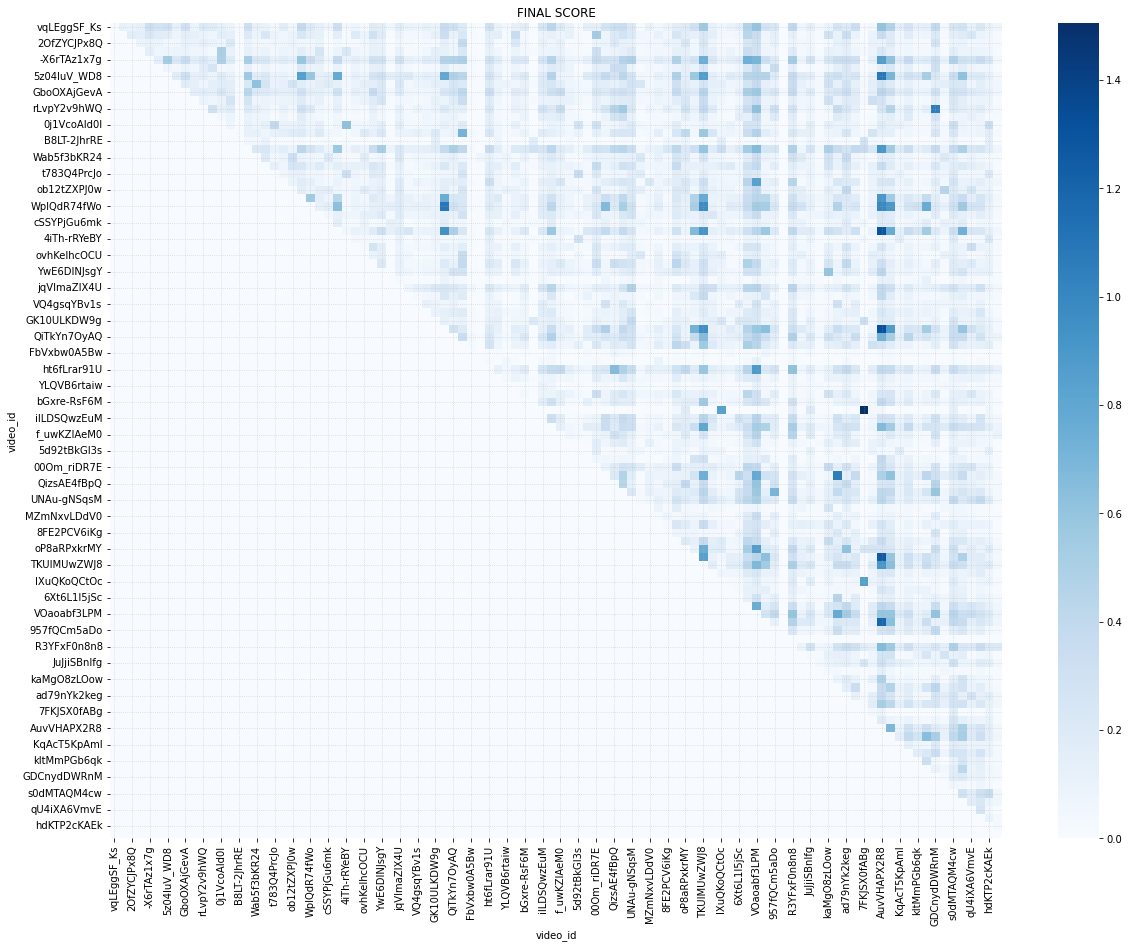

In [12]:
# Visualize a zoom of the matrix
matrix_size = 100
start = np.random.choice(len(final_score_matrix))

# Triangularise the matrix
final_score_triangular = pd.DataFrame(np.triu(final_score_matrix), columns=final_score_matrix.columns, index=final_score_matrix.index)

# Plot the results
plt.figure(figsize=(20,15))
sns.heatmap(final_score_triangular.iloc[start:start + matrix_size, start: start + matrix_size], cmap='Blues')
plt.grid(alpha=0.5, linestyle=':')
plt.title("FINAL SCORE")
plt.savefig('../assets/final_matrix_triangular.jpg', dpi=300, format='jpg', bbox_inches='tight')
plt.show();

# Future steps: model evaluation

Precision@K

$$
\text{Precision@K} = \frac{\text{Número de elementos relevantes en el top K}}{K}
$$


Recall@K
$$
\text{Recall@K} = \frac{\text{Número de elementos relevantes en el top K}}{\text{Número total de elementos relevantes}}
$$


F1-Score@K
$$
\text{F1-Score@K} = 2 \times \frac{\text{Precision@K} \times \text{Recall@K}}{\text{Precision@K} + \text{Recall@K}}
$$
